@author: Maksim Krivolapov @email: krivolapov.maksim@gmail.com

## Reccomendations 
We would also like you to describe:
1.	structure and individual steps of the solution, selection of  data representations, methods, etc.
2.	why did you choose this solution, representation, method (why not something else)
3.	how would you validate that your solution is correct (algorithm) and functional (implementation)
4.	strengths and weaknesses of your solution, what should be improved and how
5.	possible modifications/optimizations (algorithmic and product point of view) that would:
    * work and scale efficiently on large data sets (tens of GBs)
    * low response time in production


In [111]:
%%time
# load modules
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Wall time: 0 ns


In [112]:
%%time
# read out JSON file
with open('posts_with_topics.json') as f:
      data = json.load(f)
#print(data)

Wall time: 5 ms


## 1 .Read out json file into Pandas data frame.
I discarded PostId because it useless for our task

In [113]:
%%time
# read out topics into Pandas DataFrame 
new_df = pd.read_json('posts_with_topics.json')["topics"]
new_df

Wall time: 11 ms


0      [Politics, International relations, Donald Tru...
1      [Politics, Donald Trump, Political career of D...
2      [Politics, Donald Trump, Political career of D...
3      [Politics, Government, Donald Trump, Political...
4      [Politics, Donald Trump, Political career of D...
                             ...                        
342    [International security, National security, Ch...
343                                  [National security]
344                                   [Chemical warfare]
345                                             [Europe]
346                                        [Afghanistan]
Name: topics, Length: 347, dtype: object

## 2. Collect all original topics (features)
Collect and plot features frequency 

Wall time: 291 ms


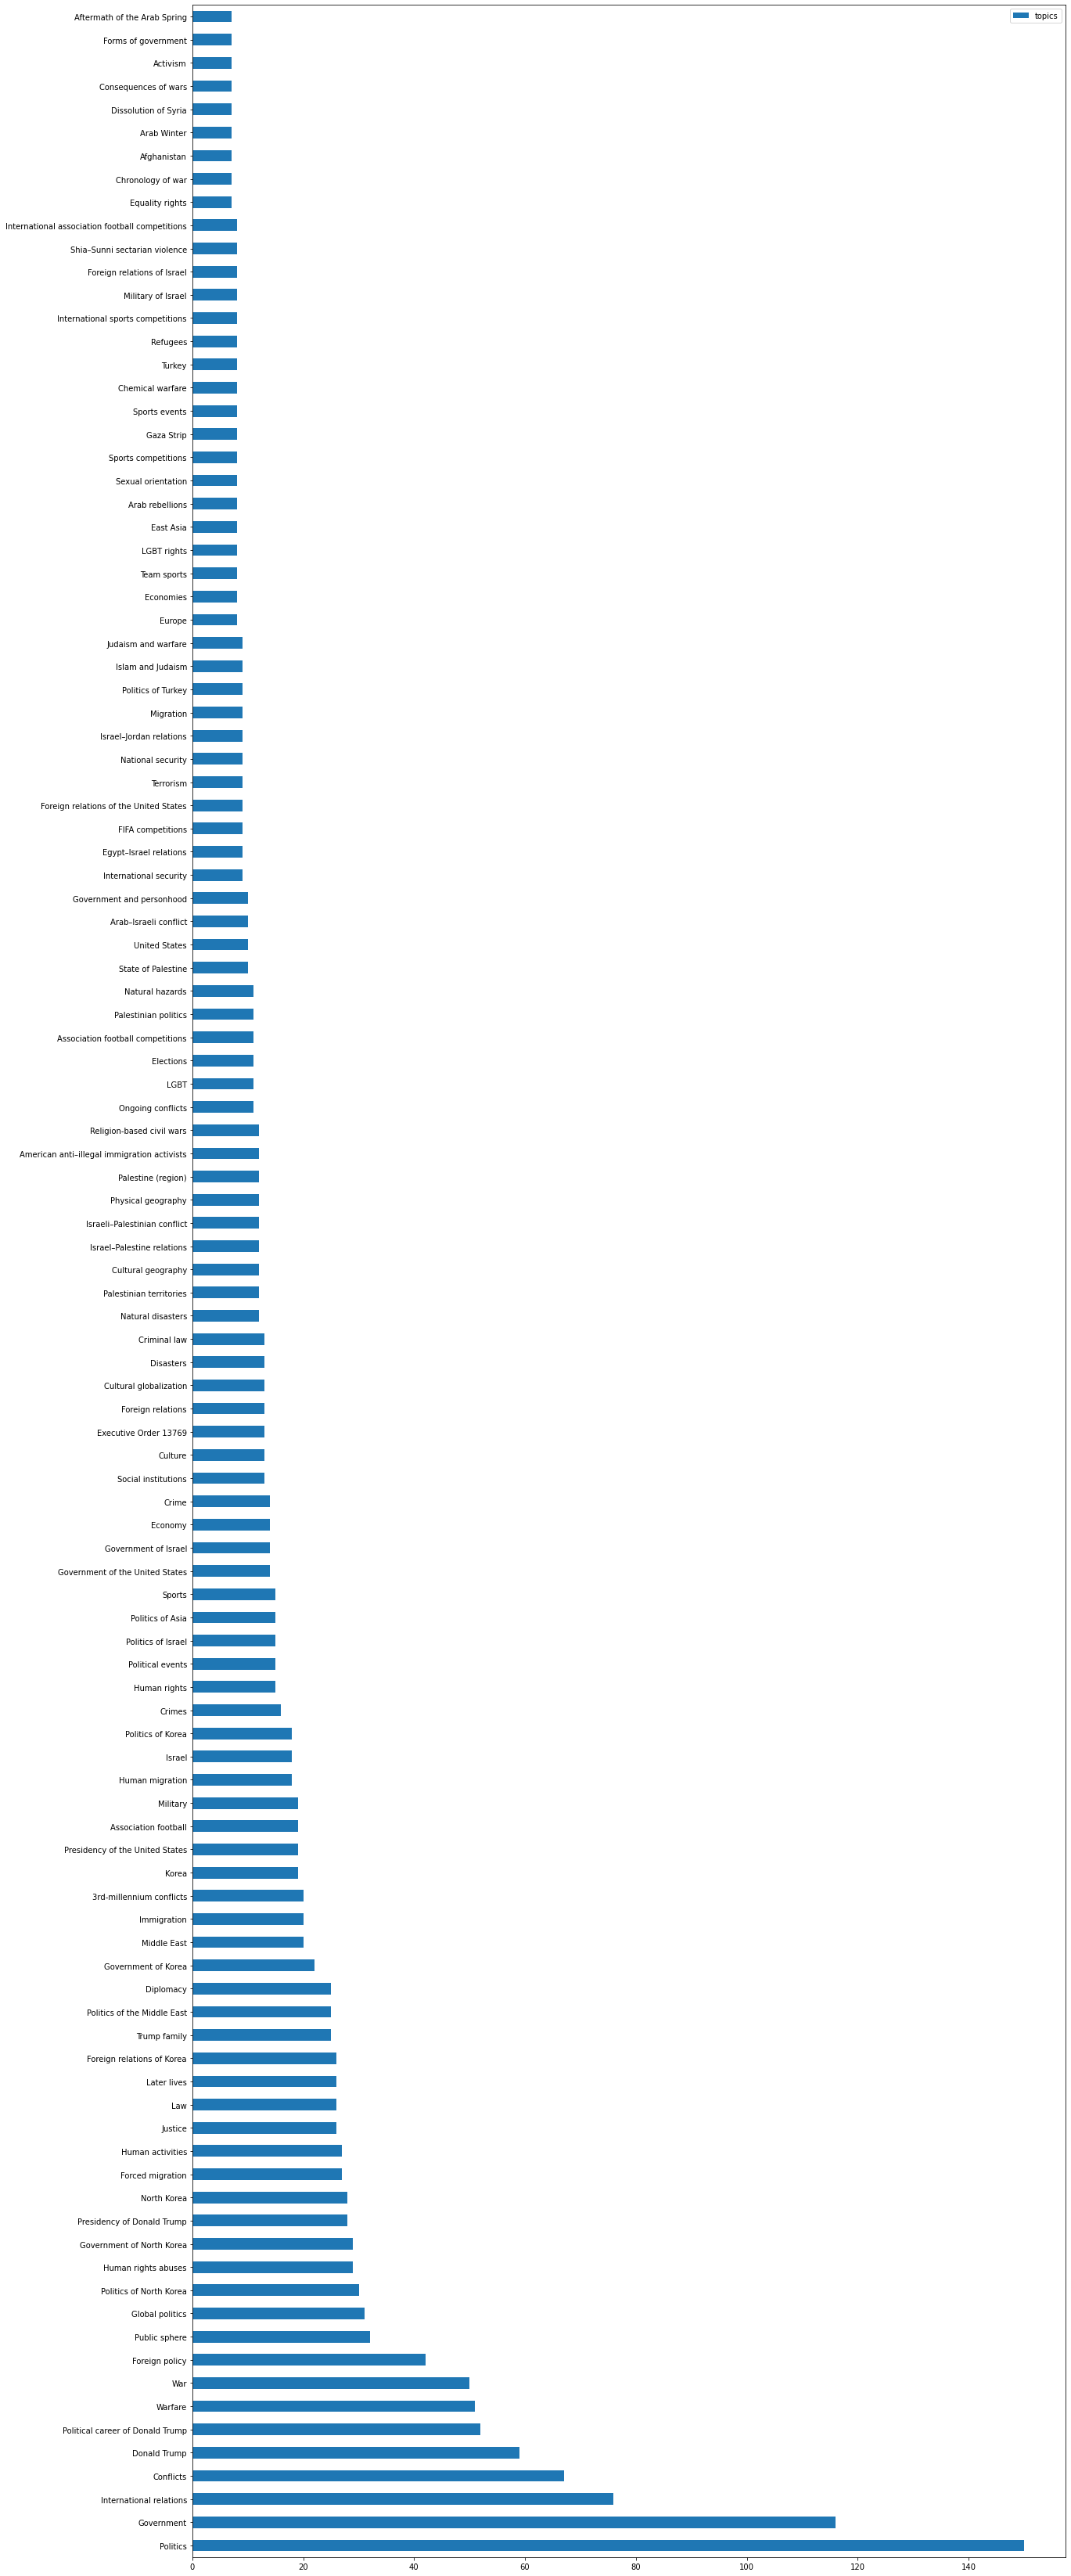

In [114]:
%%time
# parsing of JSON file and preprocedding 
# features_df cintains features and number of its appirance
features_df = pd.DataFrame(new_df.explode().value_counts())
list_of_features = pd.Series(features_df.index.to_list())
features = new_df.explode().value_counts()
features_df.plot.barh(figsize=(20,60))

## 3. Prepare empty dataframe for features
I'm going to collect all feature in binary format into that dataframe

In [115]:
%%time
df_all_features = pd.DataFrame(columns=list_of_features, dtype = 'int')

Wall time: 13 ms


In [116]:
%%time
# Features extraction - all topics in json file.

Wall time: 0 ns


## 4. Collect all features from every posts into one dataframe. 
That's not necessary for data processing, just for interim exploratory analysis.
That simple function takes a lot of time, looks strange. It needs to be rewrite.

In [117]:
%%time
for i in range(len(new_df)):
    for j in range(len(list_of_features)):
        df_all_features.loc[i, list_of_features[j]] = int(list_of_features[j] in new_df[i])
    

Wall time: 13.9 s


## 5. Calculate autocorrelation matrix 
Calculate consicuantly correlation between all features in one post and add value to matrix
That's sparce matrix and where is room for improvment overhere in part of efficiency.

In [118]:
%%time
appearance_df = pd.DataFrame(0, index = list_of_features, columns=list_of_features, dtype ='int')
for i in range(len(df_all_features)):
    appearance_df = appearance_df + df_all_features.iloc[[i]].T.dot(df_all_features.iloc[[i]])
    

Wall time: 1.31 s


## 6. Matrix normalisation
Convert future matrix into Gaussian 2D matrix. Divide every row by number of appearance of appropriate feature. 
Every cell (coll-A, row-B) contains probability A*B/B

In [119]:
%%time
# Take value from feature frequency list and divide appropriate row
appearance_df_norm = appearance_df.div(features, axis = 0)
# Set zero values for main diagonal (it will be useful for maximum value search in next step)
np.fill_diagonal(appearance_df_norm.values, 0)

Wall time: 1e+03 µs


## 7. Find cluster of words links to selected word. (feature)
Use maximisation of likelihood algorithm
algorithm steps: 1.select feature (index) 2. sequentially select one element in row and check it value (is it max in appropriate column), if it's max add feature into list.

In [120]:
%%time
# clustering of topics: get cluster around particular topic (function definition)
# matrix we get should be qudratic
def cluster_likelyhood_max(df, index):
    """ Function for getting cluster from 2D Gausian matrix. Function returns dictionary: key is a center of cluster. 
    Cluster contains key as well.  """
    result = []
    for i in range(len(df)):
        if df[index][list_of_features[i]] == df[list_of_features[i]].max():
            result.append(list_of_features[i])
        
    return {index:result}

Wall time: 0 ns


In [121]:
cluster_likelyhood_max(appearance_df_norm,list_of_features[3])

{'Conflicts': ['3rd-millennium conflicts',
  'Religion-based civil wars',
  'Egypt–Israel relations',
  'Israel–Jordan relations',
  'Islam and Judaism',
  'Judaism and warfare',
  'Arab rebellions',
  'Gaza Strip',
  'Military of Israel',
  'Foreign relations of Israel',
  'Shia–Sunni sectarian violence',
  'Chronology of war',
  'Arab Winter',
  'Dissolution of Syria',
  'Aftermath of the Arab Spring']}

## 8. Find all clusters around all features
It will be store in store in format {"Feature":[list of features connected to key + key itself]} 

In [122]:
%%time
result_data = {}
for i in range(len(appearance_df_norm)):
    result = cluster_likelyhood_max(appearance_df_norm,list_of_features[i])
    result_data = {**result_data, **result}
        

Wall time: 1.93 s


## 9. Save result into json file

In [123]:
%%time
with open('result_data.json', 'w') as fp:
    json.dump(result_data, fp,)

Wall time: 3 ms


In [124]:
%%time
# test clasterisation: folding,...

Wall time: 0 ns


## Solution
I decided to use EM-algorithm because it works good with streaming data. We can calculate probability matrix continuously. Matrix processing by pandas works pretty fast.

## Visualisation with word cloud
1. I would limit number of topics for visulalisation and for clastering (fuature extraction), but still count numbrs of occurence. Use only top 20 topics for fuature space.
2. Type should be proporortional to number of apperance of appropriate topic's name

## Possible modifications/optimizations 
1. Feature extraction from stream. Update table with frequency of feature per second. Use TOP 30 features for calculation 
2. We do not use and do ton see feature (topic) till it get into TOP_30 list.
3. Calculate covariance matrix chunk by chunk and averaging the results
4. It would be right to add number of appearance of key words into final result but I've spent all time I had :)

## Test
I would like to test implementation and algorithm itself by artificial topic added to dataset
It will affects 1: list of features (number of appearance), and probability matrix

### I have a lot of successions about task but my time is up unfortunately.